In [ ]:
#LSTM 実装
# sin波形をLSTMで予想する

ライブラリ

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

# 株価データの取得
start = '2021-01-04'
end = '2023-05-02'
tickers = 'TSLA'  # 予測対象の株価シンボル
y = yf.download(tickers, start=start, end=end)["Close"]

# データの正規化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(y.values.reshape(-1, 1))

# ランダムシードの固定化
seed_value = 42
np.random.seed(seed_value)
#random.seed(seed_value)
#tf.random.set_seed(seed_value)

# データセットの分割
#train_ratio = 0.8  # 訓練データの割合
#train_size = int(len(scaled_data) * train_ratio)
#train_data = scaled_data[:train_size]
#test_data = scaled_data[train_size:]


plt.style.use("ggplot")
%matplotlib inline

[*********************100%%**********************]  1 of 1 completed


教師データ

In [8]:
print(scaled_data.shape)
x = np.linspace(0,584,585)
yy = np.sin(x * 2 * np.pi / 50)
print(yy.shape)
print(y.shape)
y = y.squeeze()
print(y.shape)

(585, 1)
(585,)
(585,)
(585,)


(585,)


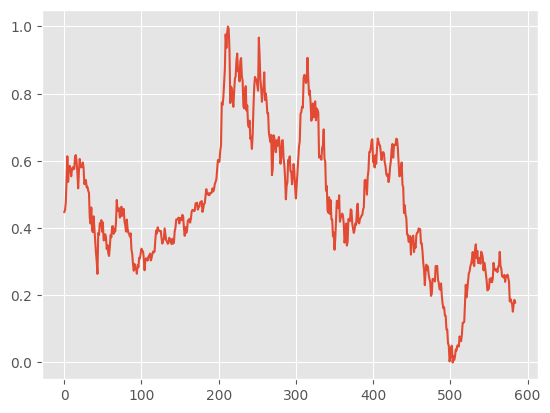

In [11]:
plt.plot(x,y)
y=scaled_data
y=y.squeeze()
print(y.shape)


窓スライド処理

In [12]:
def make_sequence_data(y, num_sequence):
  num_data = len(y)
  seq_data = [] # 4つ刻みのデータを格納する用のリスト
  target_data = [] # seq_dataの1つ次のデータを格納する用のリスト
  for i in range(num_data - num_sequence):
    seq_data.append(y[i : i + num_sequence])
    target_data.append(y[i+num_sequence : i + num_sequence + 1])
  seq_arr = np.array(seq_data)
  target_arr = np.array(target_data)
  #return seq_arr, target_arr
  return seq_arr.squeeze(), target_arr.squeeze()

In [13]:
#周期性がどの程度あるのか？ここをよく見ながら設定すること！！
seq_length = 30

In [14]:
y.shape

(585,)

In [15]:
y_seq, y_target = make_sequence_data(y , seq_length)

In [16]:
y_seq.shape

(555, 30)

In [17]:
# 今回は40刻み事なので500-40=460で　周期長が40となっている

In [18]:
print(y_seq)

[[0.44773137 0.45362794 0.47667318 ... 0.53815664 0.54308149 0.52110736]
 [0.45362794 0.47667318 0.54299313 ... 0.54308149 0.52110736 0.52323844]
 [0.47667318 0.54299313 0.61364162 ... 0.52110736 0.52323844 0.51134592]
 ...
 [0.2396727  0.2518634  0.23861267 ... 0.18037567 0.17414781 0.15122404]
 [0.2518634  0.23861267 0.24894823 ... 0.17414781 0.15122404 0.17255774]
 [0.23861267 0.24894823 0.296419   ... 0.15122404 0.17255774 0.18620598]]


In [19]:
y_target.shape

(555,)

テストデータ作成
最終10行をテストデータにする

In [20]:
num_test = 10
y_seq_train = y_seq[:-num_test]
y_seq_test = y_seq[-num_test:]
y_target_train = y_target[:-num_test]
y_target_test = y_target[-num_test:]

In [21]:
y_seq_train.shape

(545, 30)

pytorch用の処理

In [22]:
# tensorに変換する
y_seq_t = torch.FloatTensor(y_seq_train)
y_target_t = torch.FloatTensor(y_target_train)

In [23]:
y_target_t.shape
#y_seq_t.shape

torch.Size([545])

LSTMの定義
 #x_last=x[-1]は予測したラストを抽出

In [24]:
class LSTM(nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size = 1,hidden_size = self.hidden_size)
    self.linear = nn.Linear(self.hidden_size,1)

  def forward(self,x):
    x, _ =self.lstm(x)
    x_last = x[-1]
    x = self.linear(x_last)
    return x

In [25]:
#hidden size =100　隠れ層数の設定
model = LSTM(100)

Loss関数と最適化アルゴの定義

In [26]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

LSTMに入力するための処理

In [27]:
y_seq_t.size()

torch.Size([545, 30])

In [28]:
# LSTMにインプットする際に先にシーケンス上の軸が来て、つぎにバッチサイズが来る、最後にインプットサイズの軸が来る
# y_seq_tの順番が逆であるので入れ替える必要がある

In [29]:
y_seq_t = y_seq_t.permute(1,0)

In [30]:
y_seq_t.size()

torch.Size([30, 545])

In [31]:
y_target_t = y_target_t.permute(1,0)

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 1 is not equal to len(dims) = 2

In [32]:
y_target_t.size()

torch.Size([545])

In [33]:
# 40×450の2次元テンサーなので、1次元にする必要がる
 # unsqueezeはsqueezeの反対なのでsqueezeは40x450x1を絞って40x450にするがunsqueezeは次元を広げる働きがある。dim=-1にすると最後の列に1を付与できる

In [34]:
y_seq_t = y_seq_t.unsqueeze(dim=-1)
y_target_t = y_target_t.unsqueeze(dim=-1)

In [35]:
y_seq_t.shape

torch.Size([30, 545, 1])

学習トレーニング
ミニバッチのランニングLossを初期化することが通常だが
今回はバッチ学習のためいきなりOptimizerの初期化を実施します

In [36]:
num_epochs = 80
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(y_seq_t)
    loss = criterion(output, y_target_t)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    if epoch % 10 == 0:
        print("epoch: {}, loss: {}".format(epoch, loss.item()))

epoch: 0, loss: 0.22347955405712128
epoch: 10, loss: 0.06351331621408463
epoch: 20, loss: 0.03152318298816681
epoch: 30, loss: 0.030878277495503426
epoch: 40, loss: 0.02498950995504856
epoch: 50, loss: 0.019235558807849884
epoch: 60, loss: 0.011203729547560215
epoch: 70, loss: 0.008053403347730637


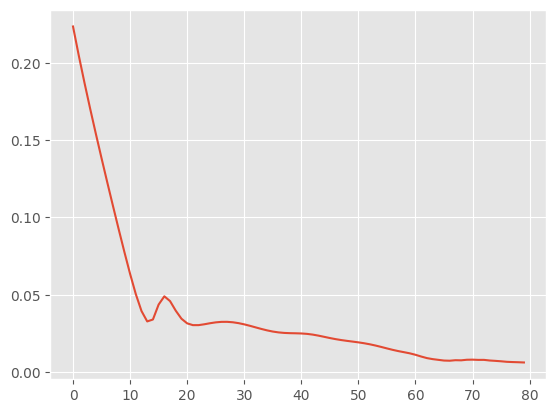

In [37]:
plt.plot(losses)

In [38]:
y_seq_test_t = torch.FloatTensor(y_seq_test)
y_seq_test_t = y_seq_test_t.permute(1,0)
y_seq_test_t = y_seq_test_t.unsqueeze(dim=-1)

In [39]:
y_seq_test_t.size()

torch.Size([30, 10, 1])

In [40]:
y_pred = model(y_seq_test_t)

In [41]:
y_pred.size()

torch.Size([10, 1])

(450.0, 500.0)

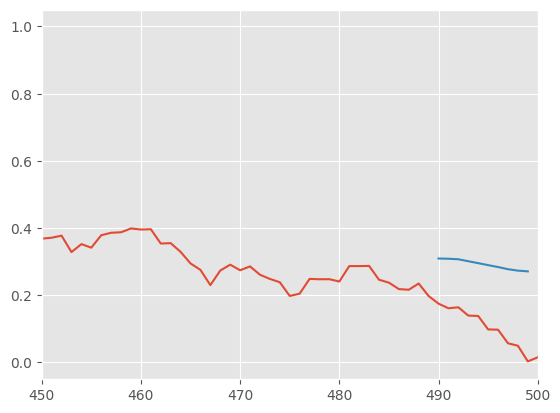

In [42]:
plt.plot(x,y)
plt.plot(np.arange(490,500),y_pred.detach())
plt.xlim([450,500])